<a href="https://colab.research.google.com/github/princekumar840946/Knn-machine-learning-model/blob/master/kaggle_titanic_dataset_example_submission_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import Dependencies
%matplotlib inline
!pip install catboost

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

### Loading in the data

After we've downloaded the data, we need to get it into the notebook.

I've stored my downloaded data in a file called `data`.

In [0]:
# Import train & test data 
train = pd.read_csv('/content/train (1).csv')
test = pd.read_csv('/content/test (1).csv')
gender_submission = pd.read_csv('/content/gender_submission (1).csv') # example of what a submission should look like

In [6]:
# View the training data
train.head(15)

PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0             1         0       3  ...   7.2500   NaN         S
1             2         1       1  ...  71.2833   C85         C
2             3         1       3  ...   7.9250   NaN         S
3             4         1       1  ...  53.1000  C123         S
4             5         0       3  ...   8.0500   NaN         S
5             6         0       3  ...   8.4583   NaN         Q
6             7         0       1  ...  51.8625   E46         S
7             8         0       3  ...  21.0750   NaN         S
8             9         1       3  ...  11.1333   NaN         S
9            10         1       2  ...  30.0708   NaN         C
10           11         1       3  ...  16.7000    G6         S
11           12         1       1  ...  26.5500  C103         S
12           13         0       3  ...   8.0500   NaN         S
13           14         0       3  ...  31.2750   NaN         S
14           15         0       3  ...   7.8542   NaN         S

[15 rows x 12 columns]

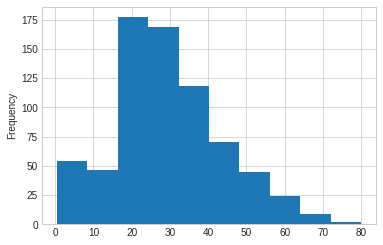

In [7]:
train.Age.plot.hist()

In [8]:
# View the test data (same columns as the training data)
test.head() # head = view first 5 lines

PassengerId  Pclass  ... Cabin Embarked
0          892       3  ...   NaN        Q
1          893       3  ...   NaN        S
2          894       2  ...   NaN        Q
3          895       3  ...   NaN        S
4          896       3  ...   NaN        S

[5 rows x 11 columns]

In [9]:
# View the example submisison dataframe
gender_submission.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

## Data Descriptions

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [10]:
train.describe()

PassengerId    Survived      Pclass  ...       SibSp       Parch        Fare
count   891.000000  891.000000  891.000000  ...  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642  ...    0.523008    0.381594   32.204208
std     257.353842    0.486592    0.836071  ...    1.102743    0.806057   49.693429
min       1.000000    0.000000    1.000000  ...    0.000000    0.000000    0.000000
25%     223.500000    0.000000    2.000000  ...    0.000000    0.000000    7.910400
50%     446.000000    0.000000    3.000000  ...    0.000000    0.000000   14.454200
75%     668.500000    1.000000    3.000000  ...    1.000000    0.000000   31.000000
max     891.000000    1.000000    3.000000  ...    8.000000    6.000000  512.329200

[8 rows x 7 columns]

## What missing values are there?

Where are the holes in our data?

These are rows which are missing a value or have NaN instead of something like the rest of the column.

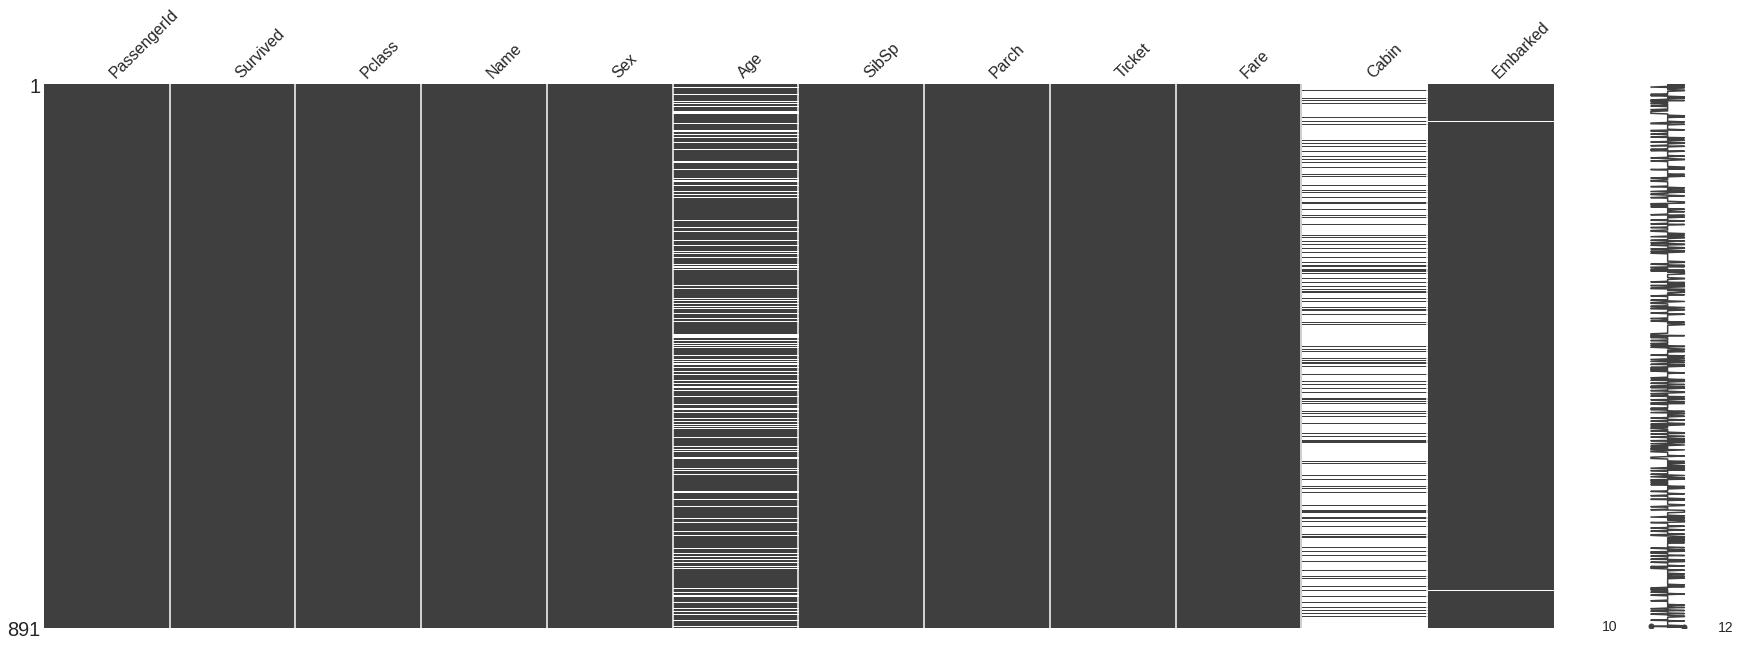

In [11]:
# Plot graphic of missing values
missingno.matrix(train, figsize = (30,10))

Ok we can clearly see some missing values here. Especially in the cabin column.

It's important to visualise missing values early so you know where the major holes are in your dataset.

Knowing this informaiton will help with your EDA and figuring out what kind of data cleaning and preprocessing is needed.

In [12]:
# Alternatively, you can see the number of missing values like this
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## To perform our data analysis, let's create two new dataframes

We'll create one for exploring discretised continuous variables (continuous variables which have been sorted into some kind of category) and another for exploring continuous variables.

In [0]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

In [14]:
# Different data types in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Let's explore each of these features individually
We'll go through each column iteratively and see which ones to use in our first models.
Some may need more preprocessing than others to get ready.

In [15]:
train.head()

PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

0    549
1    342
Name: Survived, dtype: int64


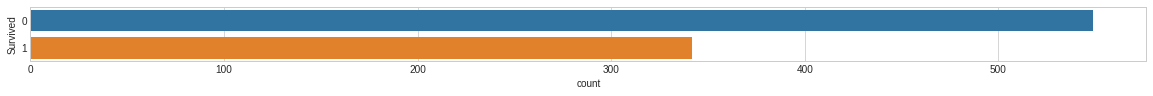

In [16]:
# How many people survived?
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train);
print(train.Survived.value_counts())

In [0]:
# Let's add this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [18]:
df_bin.head()

Survived
0         0
1         1
2         1
3         1
4         0

In [19]:
df_con.head()

Survived
0         0
1         1
2         1
3         1
4         0

### Feature: Pclass

Description: The ticket class of the passenger.
    
Key: 1 = 1st, 2 = 2nd, 3 = 3rd

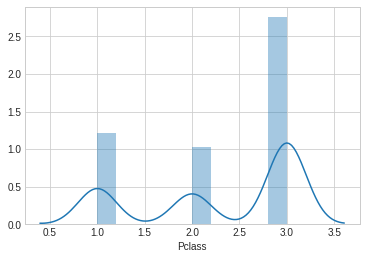

In [20]:
sns.distplot(train.Pclass)

We can see with this feature, the values are numerical (1, 2 and 3) but they are categories.

How do we know this? Because a passenger in Class 3 doesn't necessarily equal a passenger in Class 2 + a passenger in Class 1.

In [21]:
# How many missing variables does Pclass have?
train.Pclass.isnull().sum()

0

Since there are no missing values in Pclass, let's add it to our sub dataframes.

In [0]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

### Feature: Name
    
Description: The name of the passenger.

In [23]:
# How many different names are there?
train.Name.value_counts()

Johanson, Mr. Jakob Alfred       1
Leinonen, Mr. Antti Gustaf       1
Scanlan, Mr. James               1
Gustafsson, Mr. Alfred Ossian    1
Wells, Miss. Joan                1
                                ..
Badt, Mr. Mohamed                1
Aubart, Mme. Leontine Pauline    1
Ali, Mr. William                 1
McCarthy, Mr. Timothy J          1
Vanden Steen, Mr. Leo Peter      1
Name: Name, Length: 891, dtype: int64

### Feature: Sex

Description: The sex of the passenger (male or female).

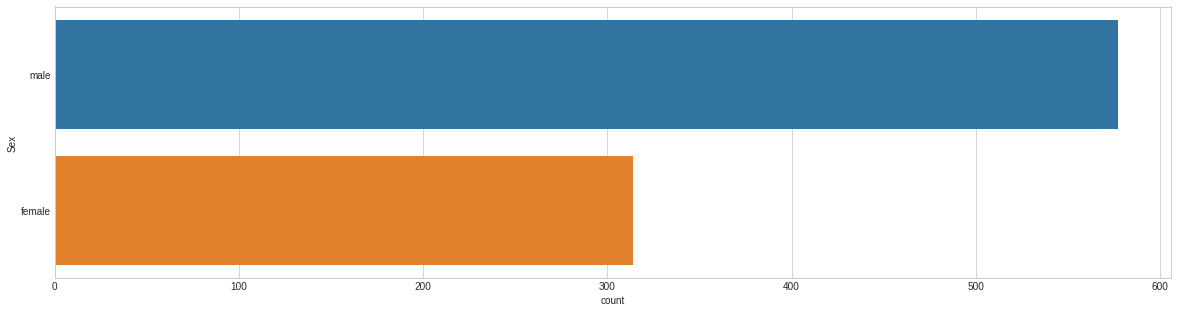

In [24]:
# Let's view the distribution of Sex
plt.figure(figsize=(20, 5))
sns.countplot(y="Sex", data=train);

In [25]:
# Are there any missing values in the Sex column?
train.Sex.isnull().sum()

0

Since this is already binary variable (male or female), let's add it straight to our subset dataframes.

In [26]:
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [0]:
# add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = train['Sex']

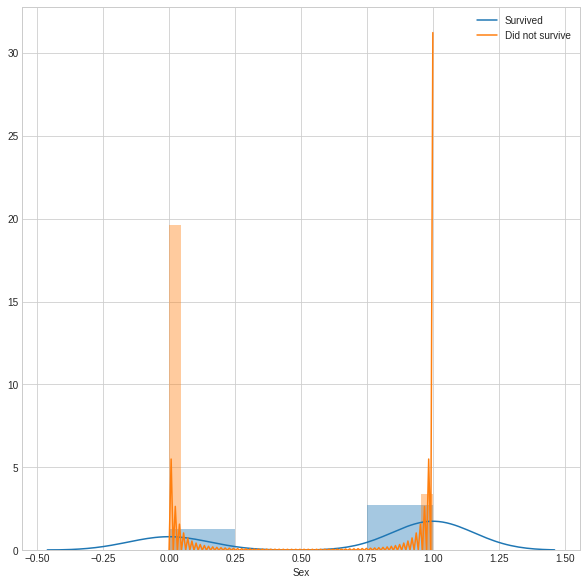

In [28]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binarys.
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

Not many people survived. But of those who did, more were female.

### Feature: Age

Description: The age of the passenger.

In [29]:
# How many missing values does age have?
train.Age.isnull().sum()

177

Out of a total 891 rows, that's almost one quarter of the dataset.

What would you do with these missing values?

Could replace them with the average age? What's the pro's and con's of doing this?

Or would you get rid of them completely?

We won't answer these questions in our initial EDA but this is something we would definitely revisit at a later date.


In [0]:
# Once the Age values have been fixed up, we can add them to our sub dataframes.
# df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
# df_con['Age'] = train['Age'] # non-bucketed

**Challenge:** How would you fill the missing variables in the `Age` column?

#### Function to create count and distribution visualisations

In [0]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

### Feature: SibSp

Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [32]:
# How many missing values does SibSp have?
train.SibSp.isnull().sum()

0

In [33]:
# What values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Let's add SibSp to our subset dataframes and view the distributions.

In [0]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

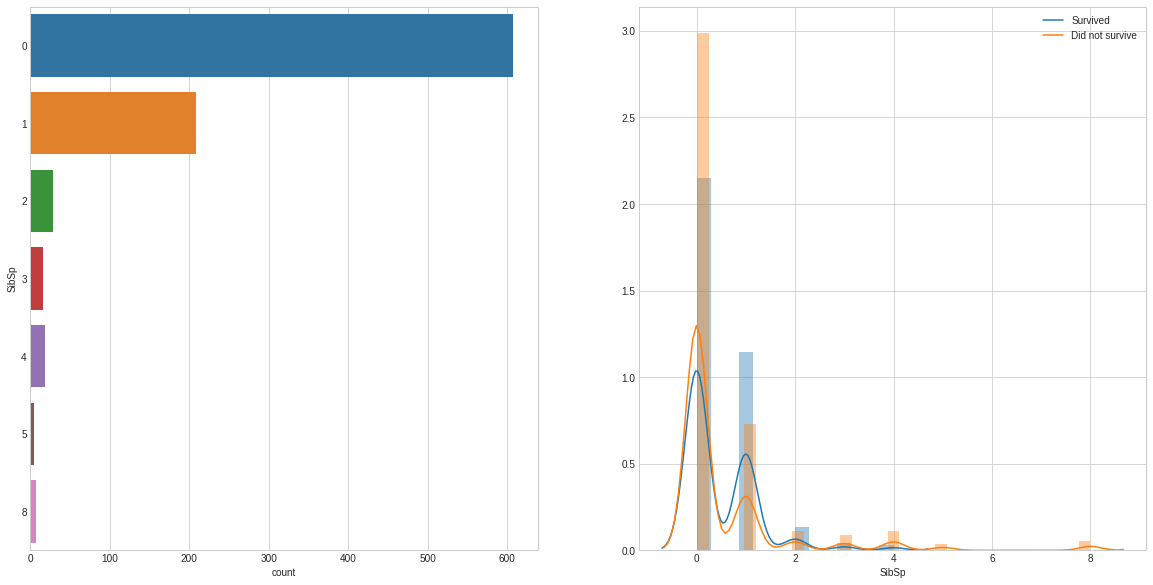

In [35]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

What does the graph on the right tell us?

### Feature: Parch

Description: The number of parents/children the passenger has aboard the Titanic.

Since this feature is similar to SibSp, we'll do a similar analysis.

In [36]:
# How many missing values does Parch have?
train.Parch.isnull().sum()

0

In [37]:
# What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [0]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

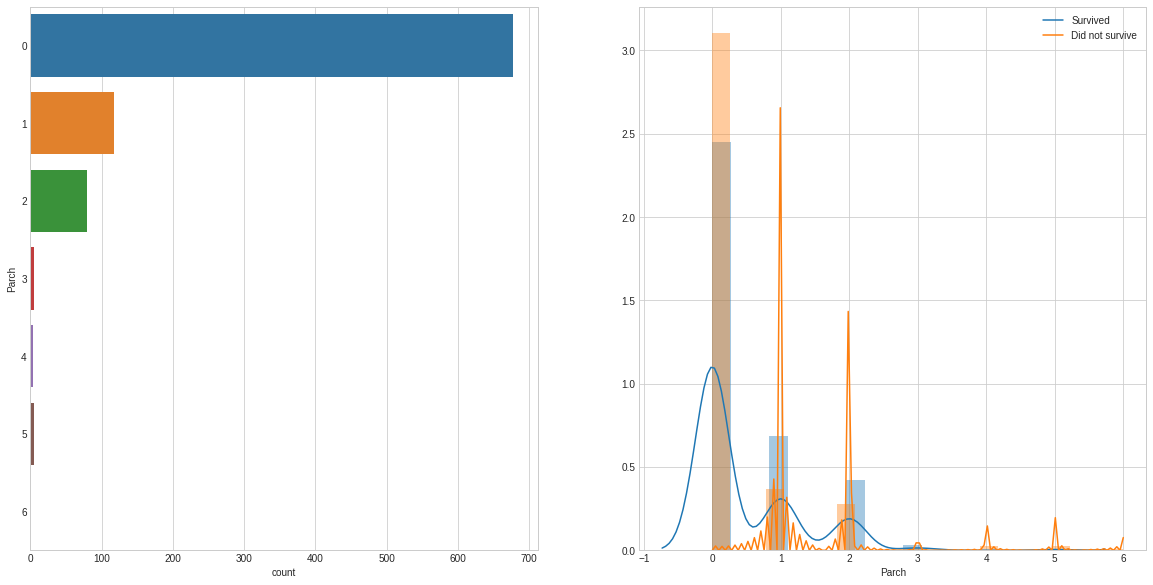

In [39]:
# Visualise the counts of Parch and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

What does the graph on the right tell us about `Parch`?

In [40]:
train.head()

PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

In [41]:
df_con.head()

Survived  Pclass     Sex  SibSp  Parch
0         0       3    male      1      0
1         1       1  female      1      0
2         1       3  female      0      0
3         1       1  female      1      0
4         0       3    male      0      0

### Feature: Ticket

Description: The ticket number of the boarding passenger.

In [42]:
# How many missing values does Ticket have?
train.Ticket.isnull().sum()

0

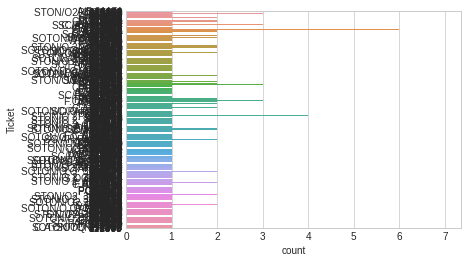

In [43]:
# How many kinds of ticket are there?
sns.countplot(y="Ticket", data=train);

That doesn't look too good, what about another way of looking at it?

In [44]:
# How many kinds of ticket are there?
train.Ticket.value_counts()

CA. 2343         7
1601             7
347082           7
347088           6
3101295          6
                ..
36568            1
W./C. 6609       1
A/5 3540         1
350052           1
SC/PARIS 2146    1
Name: Ticket, Length: 681, dtype: int64

In [45]:
# How many unique kinds of Ticket are there?
print("There are {} unique Ticket values.".format(len(train.Ticket.unique())))

There are 681 unique Ticket values.


681 unique values is too many for now. So we won't use `Ticket` in our subset dataframes.

There may be some way to reduce this down. 

**Challenge:** How could you reduce the Ticket feature? Is it even possible?

*Hint:* It may be similar to what you could do with Name.

### Feature: Fare

Description: How much the ticket cost.

In [46]:
# How many missing values does Fare have?
train.Fare.isnull().sum()

0

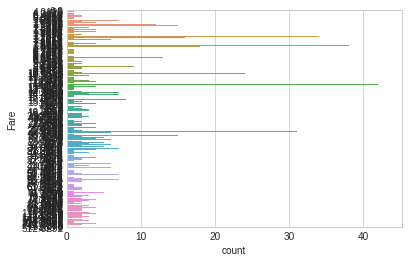

In [47]:
# How many different values of Fare are there?
sns.countplot(y="Fare", data=train);

In [48]:
# What kind of variable is Fare?
train.Fare.dtype

dtype('float64')

In [49]:
# How many unique kinds of Fare are there?
print("There are {} unique Fare values.".format(len(train.Fare.unique())))

There are 248 unique Fare values.


Because Fare is a float (number) let's add it as it is to our continuous sub dataframe but to add it to our categorical sub dataframe, we'll cut it into bins.

In [0]:
# Add Fare to sub dataframes
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised 

In [51]:
# What do our Fare bins look like?
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

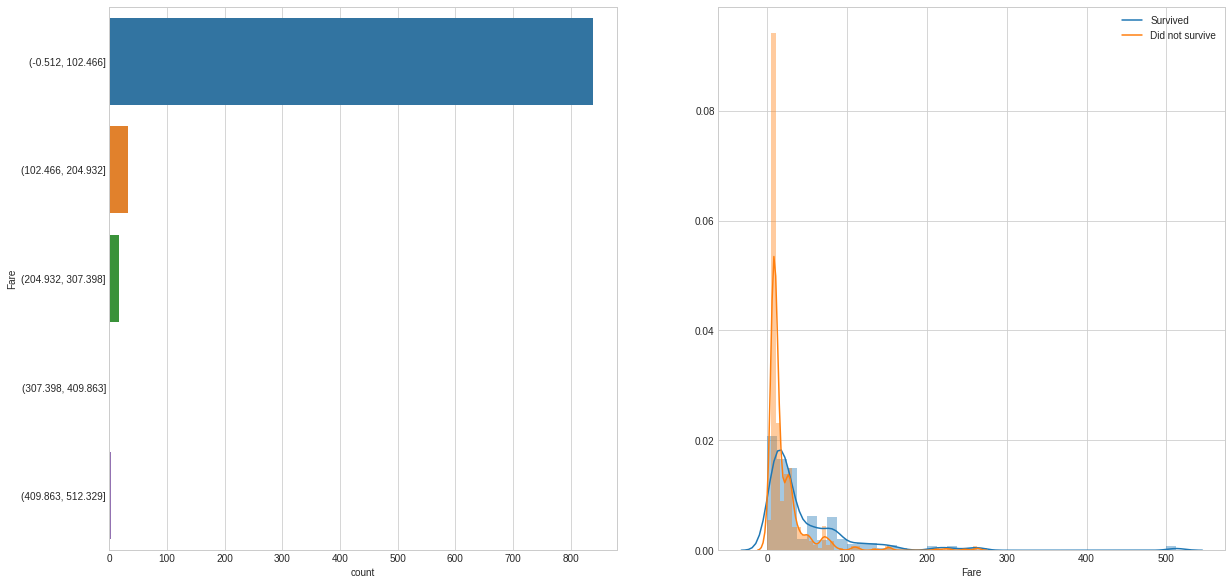

In [52]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

**Challenge:** How would you change the Fare bins?

### Feature: Cabin

Description: The cabin number where the passenger was staying.    

In [53]:
# How many missing values does Cabin have?
train.Cabin.isnull().sum()

687

In [54]:
train.head()

PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

In [55]:
# What do the Cabin values look like?
train.Cabin.value_counts()

B96 B98        4
C23 C25 C27    4
G6             4
C22 C26        3
F2             3
              ..
E31            1
B30            1
B50            1
F E69          1
B94            1
Name: Cabin, Length: 147, dtype: int64

Since there are too many missing values, we won't use Cabin for our initial models and won't add it to our sub dataframes.

But how could you modify cabin to be more usable?

What could you do about the missing values?

### Feature: Embarked

Description: The port where the passenger boarded the Titanic.
    
Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [56]:
# How many missing values does Embarked have?
train.Embarked.isnull().sum()

2

In [57]:
# What kind of values are in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked is a categorical variable because there are 3 categories which a passenger could have boarded on.

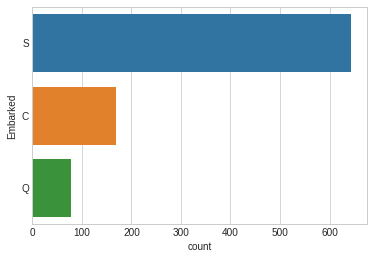

In [58]:
# What do the counts look like?
sns.countplot(y='Embarked', data=train);

#### How can we deal with the 2 missing values of Embarked?

One option is to drop the two rows which don't have an Embarked value.

Another option would be to randomly assign a value of C, Q or S to each row.

What are the pros and cons of each?

For now, we will remove those rows.

In [0]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [60]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


We've removed the two rows with missing values for Embarked, now we can add Embarked to our sub dataframes.

## Feature Encoding
Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (`df_bin`) with one-hot encoding and our continuous dataframe (`df_con`) with the label encoding function from `sklearn`.

In [61]:
df_bin.head()

Survived  Pclass  Sex  SibSp  Parch               Fare Embarked
0         0       3    0      1      0  (-0.512, 102.466]        S
1         1       1    1      1      0  (-0.512, 102.466]        C
2         1       3    1      0      0  (-0.512, 102.466]        S
3         1       1    1      1      0  (-0.512, 102.466]        S
4         0       3    0      0      0  (-0.512, 102.466]        S

In [62]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

Survived  Pclass_1  Pclass_2  ...  Embarked_C  Embarked_Q  Embarked_S
0         0         0         0  ...           0           0           1
1         1         1         0  ...           1           0           0
2         1         0         0  ...           0           0           1
3         1         1         0  ...           0           0           1
4         0         0         0  ...           0           0           1

[5 rows x 28 columns]

In [63]:
df_con.head(10)

Survived  Pclass     Sex  SibSp  Parch     Fare Embarked
0         0       3    male      1      0   7.2500        S
1         1       1  female      1      0  71.2833        C
2         1       3  female      0      0   7.9250        S
3         1       1  female      1      0  53.1000        S
4         0       3    male      0      0   8.0500        S
5         0       3    male      0      0   8.4583        Q
6         0       1    male      0      0  51.8625        S
7         0       3    male      3      1  21.0750        S
8         1       3  female      0      2  11.1333        S
9         1       2  female      1      0  30.0708        C

In [0]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [0]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [66]:
# Let's look at df_con_enc
df_con_enc.head(20)

Survived  SibSp  Parch     Fare  ...  sex_male  pclass_1  pclass_2  pclass_3
0          0      1      0   7.2500  ...         1         0         0         1
1          1      1      0  71.2833  ...         0         1         0         0
2          1      0      0   7.9250  ...         0         0         0         1
3          1      1      0  53.1000  ...         0         1         0         0
4          0      0      0   8.0500  ...         1         0         0         1
5          0      0      0   8.4583  ...         1         0         0         1
6          0      0      0  51.8625  ...         1         1         0         0
7          0      3      1  21.0750  ...         1         0         0         1
8          1      0      2  11.1333  ...         0         0         0         1
9          1      1      0  30.0708  ...         0         0         1         0
10         1      1      1  16.7000  ...         0         0         0         1
11         1      0      0  26.5500  ...         0         1         0         0
12         0      0      0   8.0500  ...         1         0         0         1
13         0      1      5  31.2750  ...         1         0         0         1
14         0      0      0   7.8542  ...         0         0         0         1
15         1      0      0  16.0000  ...         0         0         1         0
16         0      4      1  29.1250  ...         1         0         0         1
17         1      0      0  13.0000  ...         1         0         1         0
18         0      1      0  18.0000  ...         0         0         0         1
19         1      0      0   7.2250  ...         0         0         0         1

[20 rows x 12 columns]

## Start Building Machine Learning Models
Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

### Let's seperate the data

In [0]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [68]:
selected_df.head()

Survived  SibSp  Parch     Fare  ...  sex_male  pclass_1  pclass_2  pclass_3
0         0      1      0   7.2500  ...         1         0         0         1
1         1      1      0  71.2833  ...         0         1         0         0
2         1      0      0   7.9250  ...         0         0         0         1
3         1      1      0  53.1000  ...         0         1         0         0
4         0      0      0   8.0500  ...         1         0         0         1

[5 rows x 12 columns]

In [0]:
# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [70]:
# Shape of the data (without labels)
X_train.shape

(889, 11)

In [71]:
X_train.head()

SibSp  Parch     Fare  embarked_C  ...  sex_male  pclass_1  pclass_2  pclass_3
0      1      0   7.2500           0  ...         1         0         0         1
1      1      0  71.2833           1  ...         0         1         0         0
2      0      0   7.9250           0  ...         0         0         0         1
3      1      0  53.1000           0  ...         0         1         0         0
4      0      0   8.0500           0  ...         1         0         0         1

[5 rows x 11 columns]

In [72]:
# Shape of the labels
y_train.shape

(889,)

### Define a function to fit machine learning algorithms
Since many of the algorithms we will use are from the sklearn library, they all take similar (practically the same) inputs and produce similar outputs.

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [0]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Logistic Regression

In [74]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.98
Accuracy CV 10-Fold: 79.42
Running Time: 0:00:01.789907


### K-Nearest Neighbours

In [75]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 83.46
Accuracy CV 10-Fold: 76.72
Running Time: 0:00:00.192440


### Gaussian Naive Bayes

In [76]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 78.52
Accuracy CV 10-Fold: 77.95
Running Time: 0:00:00.073130


### Linear Support Vector Machines (SVC)

In [77]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 78.07
Accuracy CV 10-Fold: 75.14
Running Time: 0:00:00.433514


### Stochastic Gradient Descent

In [78]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 66.7
Accuracy CV 10-Fold: 74.35
Running Time: 0:00:00.132477


### Decision Tree Classifier

In [79]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 80.43
Running Time: 0:00:00.092933


### Gradient Boost Trees

In [80]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.61
Accuracy CV 10-Fold: 80.65
Running Time: 0:00:01.043949


### CatBoost Algorithm
CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

It's simple and easy to use. And is now regularly one of my go-to algorithms for any kind of machine learning task.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the [CatBoost docs](https://catboost.ai/).

In [81]:
# View the data for the CatBoost model
X_train.head()

SibSp  Parch     Fare  embarked_C  ...  sex_male  pclass_1  pclass_2  pclass_3
0      1      0   7.2500           0  ...         1         0         0         1
1      1      0  71.2833           1  ...         0         1         0         0
2      0      0   7.9250           0  ...         0         0         0         1
3      1      0  53.1000           0  ...         0         1         0         0
4      0      0   8.0500           0  ...         1         0         0         1

[5 rows x 11 columns]

In [82]:
# View the labels for the CatBoost model
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [83]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10])

This means Catboost has picked up that all variables except `Fare` can be treated as categorical.

In [0]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [85]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [86]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

Learning rate set to 0.009797


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6862830	total: 53.1ms	remaining: 53.1s
1:	learn: 0.6809444	total: 55.2ms	remaining: 27.5s
2:	learn: 0.6751692	total: 58.1ms	remaining: 19.3s
3:	learn: 0.6689060	total: 60.8ms	remaining: 15.1s
4:	learn: 0.6632144	total: 66.7ms	remaining: 13.3s
5:	learn: 0.6576488	total: 70.3ms	remaining: 11.6s
6:	learn: 0.6544441	total: 71.9ms	remaining: 10.2s
7:	learn: 0.6490635	total: 76.2ms	remaining: 9.45s
8:	learn: 0.6443241	total: 81.1ms	remaining: 8.93s
9:	learn: 0.6395935	total: 85.7ms	remaining: 8.48s
10:	learn: 0.6345186	total: 89ms	remaining: 8s
11:	learn: 0.6305316	total: 93ms	remaining: 7.66s
12:	learn: 0.6275610	total: 94.9ms	remaining: 7.21s
13:	learn: 0.6225020	total: 99.4ms	remaining: 7s
14:	learn: 0.6179503	total: 103ms	remaining: 6.79s
15:	learn: 0.6140480	total: 105ms	remaining: 6.46s
16:	learn: 0.6100034	total: 108ms	remaining: 6.26s
17:	learn: 0.6049646	total: 125ms	remaining: 6.8s
18:	learn: 0.6025760	total: 126ms	remaining: 6.52s
19:	learn: 0.5998630	total: 134ms	rema

### Perform CatBoost cross-validation

In [87]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6746718	test: 0.6751020	best: 0.6751020 (0)	total: 356ms	remaining: 5m 55s
1:	learn: 0.6573540	test: 0.6583602	best: 0.6583602 (1)	total: 632ms	remaining: 5m 15s
2:	learn: 0.6408329	test: 0.6429257	best: 0.6429257 (2)	total: 900ms	remaining: 4m 59s
3:	learn: 0.6253924	test: 0.6283059	best: 0.6283059 (3)	total: 1.19s	remaining: 4m 55s
4:	learn: 0.6114190	test: 0.6150989	best: 0.6150989 (4)	total: 1.45s	remaining: 4m 49s
5:	learn: 0.6004513	test: 0.6048524	best: 0.6048524 (5)	total: 1.73s	remaining: 4m 45s
6:	learn: 0.5900482	test: 0.5949158	best: 0.5949158 (6)	total: 1.98s	remaining: 4m 41s
7:	learn: 0.5800356	test: 0.5853301	best: 0.5853301 (7)	total: 2.25s	remaining: 4m 38s
8:	learn: 0.5702086	test: 0.5757925	best: 0.5757925 (8)	total: 2.51s	remaining: 4m 36s
9:	learn: 0.5612227	test: 0.5675857	best: 0.5675857 (9)	total: 2.77s	remaining: 4m 33s
10:	learn: 0.5522686	test: 0.5589941	best: 0.5589941 (10)	total: 3.03s	remaining: 4m 32s
11:	learn: 0.5447302	test: 0.5517930	best

In [88]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 83.91
Accuracy cross-validation 10-Fold: 81.32
Running Time: 0:05:23.842476


## Model Results
Which model had the best cross-validation accuracy?

**Note:** We care most about cross-validation metrics because the metrics we get from `.fit()` can randomly score higher than usual.

### Regular accuracy scores

In [89]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


Model  Score
5               Decision Tree  92.46
6     Gradient Boosting Trees  86.61
7                    CatBoost  83.91
0                         KNN  83.46
1         Logistic Regression  79.98
2                 Naive Bayes  78.52
4                  Linear SVC  78.07
3  Stochastic Gradient Decent  66.70

In [90]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


Model  Score
7                    CatBoost  81.32
6     Gradient Boosting Trees  80.65
5               Decision Tree  80.43
1         Logistic Regression  79.42
2                 Naive Bayes  77.95
0                         KNN  76.72
4                  Linear SVC  75.14
3  Stochastic Gradient Decent  74.35

We can see from the tables, the CatBoost model had the best results. Getting just under 82% is pretty good considering guessing would result in about 50% accuracy (0 or 1).

We'll pay more attention to the cross-validation figure.

Cross-validation is more robust than just the `.fit()` models as it does multiple passes over the data instead of one.

Because the CatBoost model got the best results, we'll use it for the next steps.

**Challenge:** How could you improve the CatBoost model?

## Feature Importance
Which features of the best model were most important for making predictions?

In [0]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png') 

imp         col
4    0.992061  embarked_Q
3    1.213711  embarked_C
5    1.677219  embarked_S
9    2.178083    pclass_2
8    3.243021    pclass_1
0   10.797435       SibSp
10  11.205450    pclass_3
1   13.988886       Parch
2   15.753218        Fare
6   17.695520  sex_female
7   21.255397    sex_male

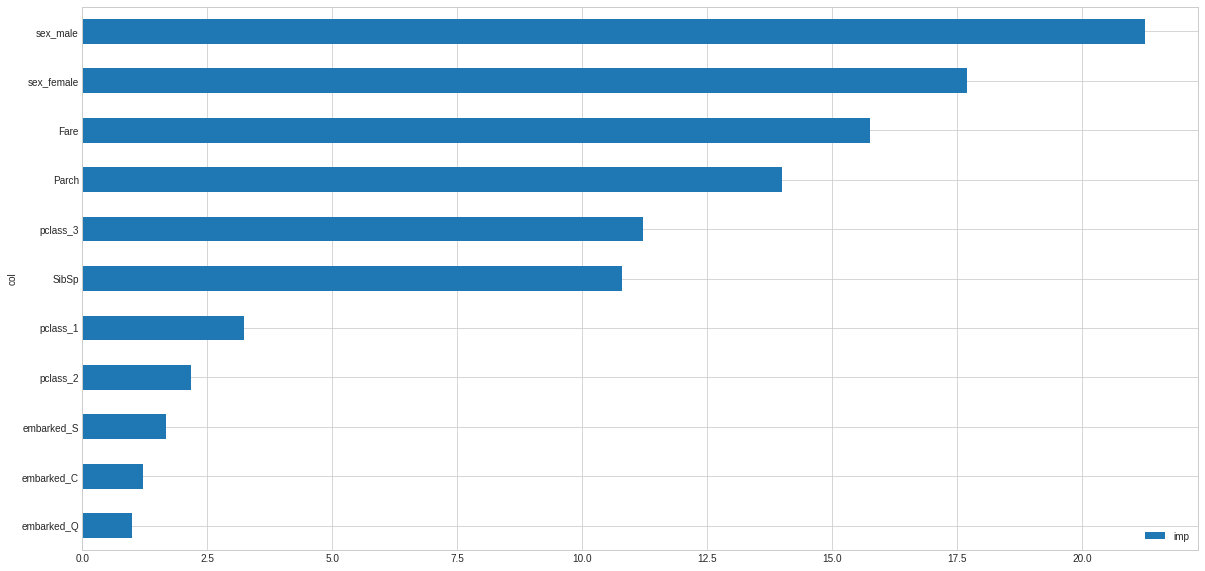

In [92]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

In [93]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8286662683284687
Recall: 0.6833382352941176
F1: 0.7489789466084935
AUC: 0.8842839467480982


## Submission
Let's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset and then submit our predictions to Kaggle.

In [94]:
# We need our test dataframe to look like this one
X_train.head()

SibSp  Parch     Fare  embarked_C  ...  sex_male  pclass_1  pclass_2  pclass_3
0      1      0   7.2500           0  ...         1         0         0         1
1      1      0  71.2833           1  ...         0         1         0         0
2      0      0   7.9250           0  ...         0         0         0         1
3      1      0  53.1000           0  ...         0         1         0         0
4      0      0   8.0500           0  ...         1         0         0         1

[5 rows x 11 columns]

In [95]:
# Our test dataframe has some columns our model hasn't been trained on
test.head()

PassengerId  Pclass  ... Cabin Embarked
0          892       3  ...   NaN        Q
1          893       3  ...   NaN        S
2          894       2  ...   NaN        Q
3          895       3  ...   NaN        S
4          896       3  ...   NaN        S

[5 rows x 11 columns]

In [0]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [0]:
# Combine the test one hot encoded columns with test
test = pd.concat([test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [98]:
# Let's look at test, it should have one hot encoded columns now
test.head()

PassengerId  Pclass  ... pclass_2 pclass_3
0          892       3  ...        0        1
1          893       3  ...        0        1
2          894       2  ...        1        0
3          895       3  ...        0        1
4          896       3  ...        0        1

[5 rows x 19 columns]

The columns in `test` have been converted to the same format at `df_con_enc`. Now we can make predictions on the `test` dataframe columns we built a model on.

We can find the columns we made predictions on with `X_train.columns`.

In [99]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [0]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns])

In [101]:
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

In [102]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

In [103]:
# What does our submission have to look like?
gender_submission.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

We need our `submission` dataframe to look like the `gender_submisison` dataframe, so we'll turn the `Survived` column into integers.

In [104]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [105]:
# How does our submission dataframe look?
submission.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

In [106]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [109]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('../catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [108]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("../catboost_submission.csv")
submissions_check.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1